\begin{titlepage}

% Photo of FS
\centering
\vspace{-40pt}
\includegraphics[width=0.8\textwidth]{Frankfurt_School_Logo.jpg}\par
\vspace{2.5cm}

% Course
{\scshape\huge Assignment 1 \par}
\vspace{2.5cm}

% Title
{\Huge\bfseries Covid-19 \& PCA Disasters \par}
{\scshape\large Studying the SIRD Model and Surrogate Data \par}

\vspace{2cm} % If signature is taken might have to add space.


{\Large Yannik Suhre \par}
{\Large Skyler MacGowan \par}
{\Large Debasmita Dutta \par}
{\Large Sebastian Sydow \par}
\vspace{0.5cm}

% Date
\vfill
{\large \today\par}
\end{titlepage}


\newpage

\hypersetup{linkcolor=black}
\tableofcontents

\newpage

# Introduction

The following document provides our solutions for the given exercises. 

# Question 1

This code is based on prior work conducted by Jan Nagler; the modications made were effectuated in order to solve the following exercise problems:

* **a**. Derive the corresponding system of equations for $S$, $I$, $R$ and $D$. E.g., $\frac{dD}{dt} = \mu I$ but this is not the only difference to $SIR$. In addition, the basic reproduction number may now depend on $\mu$ as well, how? 

* **b**. Assume that the basic reproduction number $R_0$ for B.1.1.7 is not exactly known but only the range $R_0 \in [3.0; 4.0]$. Assume that the mortality rate $\mu$ is also not exactly known but only the range $\mu \in [0.4\%; 4\%]$. Study how these parameter uncertainties affect the prediction of $D$ at $t = 365d$.

* **c**. Study numerically the effects of a hard versus soft lockdown (by two for you reasonable values of $\beta$), in terms of $D(365d)$. Assume $\mu$ = 1% and a $R_0$ of your choice.

* **b,c** Can you find a way to derive and plot the effective reproduction number, $R_{effective}$, as a function of time, given otherwise fixed parameters ?

We will start by importing some packages that can be leveraged when solving the exercise problems.

In [1]:
#### Imports ####
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
from matplotlib import cm
from IPython.display import display, Markdown
from mpl_toolkits.mplot3d import Axes3D

# set matplotlib fontsize
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# set matplotlib to inline
%matplotlib inline

## Class Explanation

In order to incorporate all the different things, and to do this with as less code as possible, we will define a class. Which methods this class contains and how the different methods work, will be displayed here.

$\underline{Note}$: Bear in mind, that the following section will outline the docstrings for the different methods. Thus, these docstrings will **not** be displayed in the code when creating the class itself.

### Class creation

The overall class is called ```SIRD``` in order to make explicit what this function is used for. It is defined like
```python
class SIRD():
   """This class alters the SIR model from Epidemiology in order
   to incorporate the deaths caused by the desease"""
```

Classes contain different methods and attributes. A method is defined within the class context as a normal function, using the ```def ...``` notation. Be aware, that since that method is defined **within** the class, it is only accessable through the class, meaning we have to use the class object in order to execute it.

In order to give a class its attributes we can make use of the ```self```. Using this name we can create and update parameters which belong to the class (*how this is done exactly will be shown later*). In order to have a clear overview, of how to create a class and which parameters to give it, let us explain the double underscore (*dunder*) function ```__init__()```. This is the function, which will be called, when the object is instantiaded (*E.g. ```SIRD()```; the ```()``` means instantiaded in this context*).

```Python
def __init__(self, N: int, I0: float, R0: float, D0: float, beta: float,
                 gamma: float, mu: float, recovery_in_days: int,  days: int):
    """This functions adds the given parameters to the object, which
    is instantiated using the SIRD class.
    
    Within this class, we also calculate R_nought, the basic reproduction
    number R_0 (pronounced R-nought) which is the average number of cases
    directly generated by one case in a population where all individuals
    are susceptible to infection using the formula
    R_nought = beta / (gamma + mu) and we calculate S0, which displays
    the number of susceptible persons, using the formula 
    S0 = N - I0 - R0 - D0.

    Parameters
    ----------
    N : int
        Represents the populations size, if you set it to 1,
        the model will ignore N and it will return fractions
    I0 : float
        The total number of infected people at time zero
    R0 : float
        The total number of recovered people at time zero
    D0 : float
        The total number of death at the time zero
    beta : float
        The contact rate, more specifically the number of lengthy
        contacts a person has per day
    gamma : float
        The recovery rate, the rate of how fast infected people
        recover from the disease
    mu : float
        The mortality rate, the rate of how many of the infected
        people die per one unit of time
    days : int
        The timeframe, how long we will model the infectious disaster
    """
```

### Derivate function

Next we can set up the $SIR(D)$ model. For the most part this is the function developed by Jan Nagler, albeit with some modifications that allow us to incorperate the mortility rate $\mu$.

```python
def _deriv(self, y, t, N, beta, gamma, mu):
    """Altered function of the SIR model,
    in order to incorporate the deaths,
    mu.

    Parameters
    ----------
    y : ndarray
        This array contains the initial values
        of S0, I0, R0 and D0
    t : np.array
        A np.array created using np.linespace in
        order to model the time
    N : int
        The population size or 1
    beta : float
        The contact rate, more specifically the number of lengthy
        contacts a person has per day
    gamma : float
        The recovery rate, the rate of how fast infected people
        recover from the disease
    mu : float
        The mortality rate, the rate of how many of the infected
        people die per one unit of time
    """
```

### Effective reproduction number

Yet another very important number when it comes to epidemiology is the **effective reproduction number**, which will be denoted by $R_{effective}$. The idea behind this number is that at any given time $t$ an unknown number of the susceptible population is immune to the disease, *or the average number of new infections caused by a single infected individual at time t in the partially susceptible population* [[3](https://en.wikipedia.org/wiki/Basic_reproduction_number#Effective_reproduction_number), [4](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory)]. As soon as this number drops below one, the prevalence of the virus within the population is decreasing. Thus $R_e$ can be defined by $R_0 * \frac{susceptibles}{population}$.

For our model, we can calculate this using the following method.

```python
def _R_effective(self, subplot = False):
    """Calculates the effective reproduction number
    based on the formulae given by Jan Nagler.

    Parameters
    ----------
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, by default False
    """
```

### Ordinary differential equation

Now, we will make use of the ```odeint()``` function, which *integrates a system of ordinary differential equations* [[2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)]. The first argument for this function must be therefore a callable object, such as a function (e.g. *a callable object is everything which can be called using ```()```*). Its second argument is the vector with the initial values. Third, we have to specify the time variable; this was also done above ($t$) in the ```__init__()``` function. In order to pass the function arguments to our given method, we also need to specify the argument `args` with all the inputs the callable needs.

```python
def _ode(self):
    """Integrates different ordinary differential
    equations."""
```

### Calculate $\beta$

In question 1.b the solution requires us to vary $R_{nought}$ and $\mu$. Since those two parameters are depended $\beta$, we have to recalculate this. Hence our class has a function for it.

```python
def _get_beta(self, R_nought, mu):
    """Returns beta and the
    infectious power of R.
    
    Parameters
    ----------
    R_nought : float
        The basic reproduction number R_0
        (pronounced R-nought) which is the
        average number of cases directly
        generated by one case in a population
        where all individuals are susceptible
        to infection
    mu : float
        The mortality rate, the rate of how many of the infected
        people die per one unit of time
    """
```

### Plot $\mu$ and $R_{nought}$ w.r.t. cumulated deaths

Until now, we have just dealt with methods/functions that commence with an underscore; these are known as *private* functions. Private functions should **not** be used by anyone outside of the developer team. The purpose for developing such *private* functions is that they can then be used in the *public* functions of this class.

From here onwards, we will present our *public* functions. The first one is a function which allows us to plot $\mu$ and $R_{nought}$ w.r.t. the cumulated deaths.

```python
def plot_mu_bn_wrt_cd(self, R_nought, mu, subplot = True):
    """This function makes use of the private functions,
    in order to calculate the fraction of deaths for
    question 1.b.
    
    Parameters
    ----------
    R_nought : float
        The basic reproduction number R_0
        (pronounced R-nought) which is the
        average number of cases directly
        generated by one case in a population
        where all individuals are susceptible
        to infection
    mu : float
        The mortality rate, the rate of how many of the infected
        people die per one unit of time
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, False by default
    """
```

### Plot

Lastly, in order to plot all of our things, we need to define a plotting function. This is done in the next step.

```python
def plot(self, subplot = False):
    """This function also uses all of 
    the private functions defined above 
    before plotting a graph that 
    visualizes the different functions.
    
    Parameters
    ----------
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, False by default
```

## Class definition

As shown above, a number of variables and functions are needed to solve the exercises problems. In the next cell, we will define a class that incorporates said variables/functions. The advantage of using a class is that we can easily change a given parameter and readily see/understand how doing so impacts the other parameters at play.

$\underline{Note}$: Should any questions arise regarding the methods employed, please scroll up and review the respective docstrings.

In [2]:
class SIRD:

    def __init__(self, N: int, I0: float, R0: float, D0: float, beta: float,
                 gamma: float, mu: float, days: int):
        self.N = N
        self.S0 = N - I0 - R0 - D0
        self.I0 = I0
        self.R0 = R0
        self.D0 = D0
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.R_nought = beta / (gamma + mu)
        self.t = np.linspace(0, days, days)
    
    def _deriv(self, y, t, N, beta, gamma, mu):
        S, I, R, D = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I - mu * I
        dRdt = gamma * I
        dDdt = mu * I
        return dSdt, dIdt, dRdt, dDdt
    
    def _R_effective(self, subplot = False):
        self.t_1 = 0
        for time in range(0,len(self.S)):
            if self.R_nought*self.S[time]/self.N < 1: 
                self.t_1 = time
                break
        if not subplot:
            display(Markdown(rf"$R_e$ <= 1 after {self.t_1} days!"))
    
    def _ode(self):
        y0 = self.S0, self.I0, self.R0, self.D0
        ret = odeint(self._deriv, y0, self.t, args=(self.N, self.beta, self.gamma, self.mu))
        self.S, self.I, self.R, self.D = ret.T
        
    def _get_beta(self, R_nought, mu):
        self.beta = R_nought*(self.gamma + mu)
    
    def plot_mu_bn_wrt_cd(self, R_nought, mu, subplot = True):
        self._get_beta(R_nought, mu)
        self._ode()
        self._R_effective(subplot)
        self.fraction_deaths = self.D[-1]/self.N
        return self.fraction_deaths
        
    def plot(self, subplot = False):
        self._ode()
        self._R_effective(subplot)
        fig = plt.figure(facecolor='w', figsize = (16,8))
        ax = fig.add_subplot(111, axisbelow=True)
        ax.plot(self.t, self.S/self.N, alpha=0.5, lw=2, label='$S_{usceptible}$')
        ax.plot(self.t, self.I/self.N, alpha=0.5, lw=2, label='$I_{nfected}$')
        ax.plot(self.t, self.R/self.N, alpha=0.5, lw=2, label='$R_{ecovered}$')
        ax.plot(self.t, self.D/self.N, alpha=0.5, lw=2, label='$D_{eath}$')
        ax.plot(self.t, self.R_nought*self.S/self.N, alpha=0.5, lw=2, label='$R_{effective}$')
        ax.plot(self.t, np.full(len(self.t), self.R_nought), alpha=0.5, lw=2, label='$R_{nought}$')
        ax.set_xlabel('Time / Days')
        ax.set_ylabel('Fraction of N')
        ax.set_ylim(0,2.2)
        ax.vlines(self.t_1, 0, 1, colors='k', linestyles='dashed')
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend(fontsize="large", loc = "upper right")
        legend.get_frame().set_alpha(0.5)
        
        plt.text(0.2, 0.75, f"The BRN is: {round(self.R_nought,2)}",
                     transform=ax.transAxes)
        plt.text(0.2, 0.4, f"D = t(365): {round(sum(self.D),2)}",
                     transform=ax.transAxes)
        
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        if subplot:
            x = list(map(lambda x: plt.gca().lines[x].get_xdata(), range(5)))
            y = list(map(lambda x: plt.gca().lines[x].get_ydata(), range(5)))
            lines, labels = ax.get_legend_handles_labels()
            plt.close()
            return x, y, lines, labels
        else:
            plt.show()

Now lets use this class, in order to instantiated it.

In [3]:
model = SIRD(N = 1, I0 = 0.02, R0 = 0, D0 = 0,
            beta = 0.39, gamma = 0.15, mu = 0.01,
            days= 365)

## Question 1a)

**Initial BRN Equation**
\begin{equation}
R_0=\frac{\beta}{\gamma}
\end{equation}
The equation above is the initial way in which the the Basic Reproduction Number (BRN, as represented by $R_0$) was calculated. The BRN represents the average number of people one infected person will pass the virus on to. The two independent variables are:

- *Contact Rate ($\beta$)* - Describes the average number of close contacts per day of each individual in the population.
- *Recovery Rate ($\gamma$)* - Describes the daily rate at which infected people recover from the virus ("recover" in this context includes individuals who died and hence are assumed to no longer have any infectious potential). For example, we used a $\gamma$ of 0.15, meaning we are expecting each infected individual in the population to take an average of $\frac{1}{0.15} = 6.67$ days to "recover".



    
**BRN Equation after Incorporating the Mortality Rate**

One shortcoming of the Initial BRN Equation is that it groups all individuals who have had the virus and hence are no longer seen as being susceptible to the virus together through the recovery rate. This of course is not reflective of the reality, where a portion of the "previously infected and no longer susceptible" group would be those individuals who were killed by the virus. To capture this, the modified BRN equation below breaks down the recovery rate into two variables, a "true" recovery rate that indicates the average daily rate at which an infected individual recovers (meaning that he/she actually survives) as well as the virus's mortality rate, as represented by $\mu$. Below is the modified BRN equation.
\begin{equation}
R_0=\frac{\beta}{\gamma+\mu}
\end{equation}
$\underline{Note}$: Treating a cadaver as having no infectious potential may be erroneous, but considering how one might incorporate this the infectious potential of deceased individuals is beyond the scope of this assignment. Our model is also limited by the fact that the mortality rate does not account for natural deaths, assuming simply that all deaths were a result of the virus. 

---

## Question 1b)

### Code for Visualization

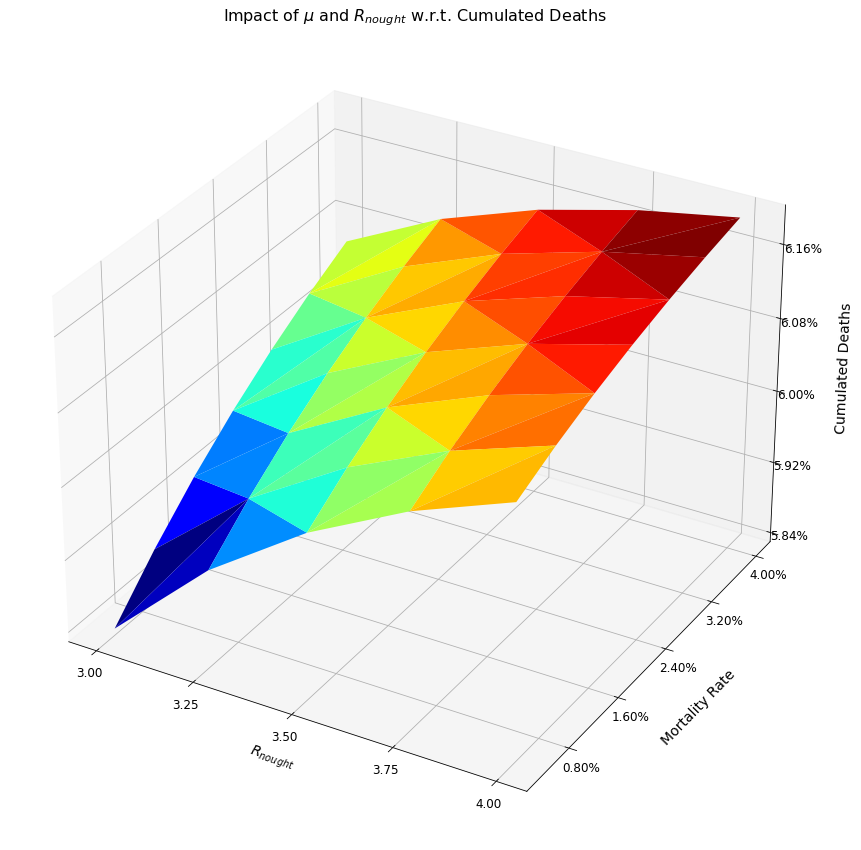

In [4]:
# range of r_nought:
r_nought = list(map(lambda x: x/100, range(300, 401, 25)))
    
# range of mortality rate:
mu = list(map(lambda x: x/1000, range(4, 41, 6)))

# create empty lists
r_nought_plot, mortalility_rate_plot, cum_deaths_plot = [], [], []

for i in r_nought:
    for j in mu:
        fraction_dead = model.plot_mu_bn_wrt_cd(i, j)
        
        r_nought_plot.append(i)
        mortalility_rate_plot.append(j)
        cum_deaths_plot.append(fraction_dead)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(r_nought_plot,
                       mortalility_rate_plot,
                       cum_deaths_plot,
                       linewidth=0.5, cmap=cm.jet, antialiased=True)
ax.set_title("Impact of $\mu$ and $R_{nought}$ w.r.t. Cumulated Deaths")
ax.set_xlabel('$R_{nought}$', labelpad = 10)
ax.set_ylabel('Mortality Rate', labelpad = 20)
ax.set_zlabel('Cumulated Deaths', labelpad = 20)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2, symbol='%', is_latex=False))
ax.zaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2, symbol='%', is_latex=False))
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.zaxis.set_major_locator(MaxNLocator(5))
plt.show()

### Written Response
The three-dimensional graph above shows the effect of different BRNs and mortality rates on cumulative deaths over a 365 day period. Specifically, the cumulative deaths are highest when both the mortality rate and the BRN have their highest values, respectively 4% and 4. Of these two variables, increases in the mortality rate have a more profound impact on the ensuing deaths. 

---

## Question 1c)

### Code for Visualization

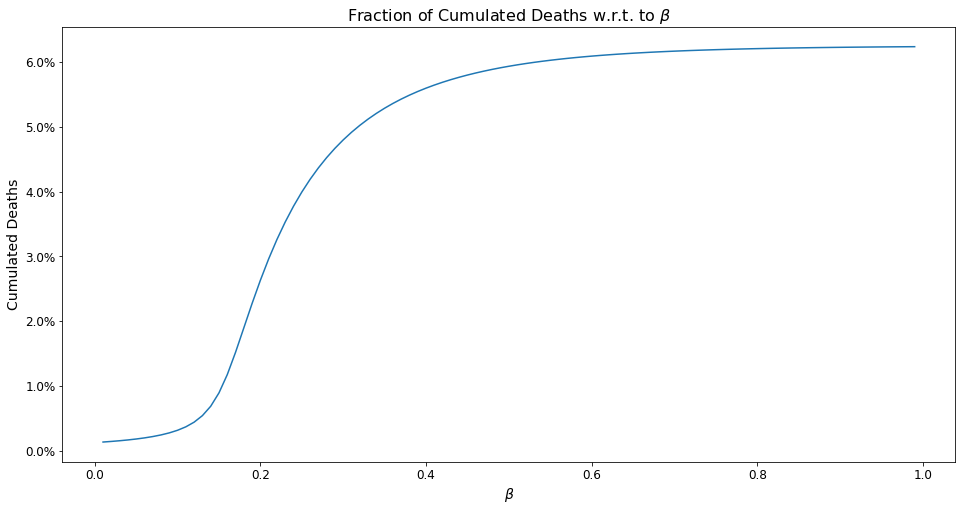

In [5]:
model.mu = 0.01
betas = list(map(lambda x: x/100, range(1, 100, 1)))[::-1]
cum_deaths, beta = [], []
for infection_rate in betas:
    model.beta = infection_rate
    model.R_nought = model.beta / (model.gamma + model.mu)
    fraction_dead = model.plot_mu_bn_wrt_cd(model.R_nought, model.mu)
    cum_deaths.append(fraction_dead)
    beta.append(infection_rate)
    
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
plt.plot(beta, cum_deaths)
plt.title(r"Fraction of Cumulated Deaths w.r.t. to $\beta$")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=1, symbol='%', is_latex=False))
plt.xlabel(r"$\beta$")
plt.ylabel("Cumulated Deaths")
plt.show()

### Written Response

The graph above illustrates cumulative deaths over a one year period using different values for the contact rate, meant to portray different lockdown scenarios. As the graph shows, cumulative deaths are greatest when the contact rate is largest, as a larger contact rate increases the virus's BRN, thereby increasing the extent to which it is disseminated throughout the general population. 

One obvious feature of this graph is that the cumulative deaths increase rapidly to about 5% as the contact rate rises to 0.3, maxing out at approximately 6% thereafter. In terms of the extent of lockdown required, this graph shows it is absolutely critical to keep the beta as low as possible, and that the beneficial effects of reducing the contact rate have are much more profound before the contact rate hits 0.2. In fact, the maxing out of the cumulative death rate around 6% presumably reflects a scenario in which the population no longer has a significant amount of susceptible persons, due to immunity built-up through exposure to the virus as well as the deceased persons.

$\underline{Note}$: Another potential limitation of our model is the assumption that those who were exposed to the virus and fought it off are no longer susceptible to it. Our understanding is that this assumption is true for some viruses but not others. There may also be a grey area, where previous exposure to the virus makes one less susceptible to it, without making that individual completely unsusceptible. Anything more than a cursory mention of these epidemiological factors however is beyond the scope of this assignment.

---

## Question 1b, c)

### Code for Visualization

In the following cell, one can see how to access a function/method through a class object. Earlier we instantiated the model to be an object of class ```SIRD```. Now, we can use the dot notation (```.plot()```) to access the ```plot``` function.

$R_e$ <= 1 after 19 days!

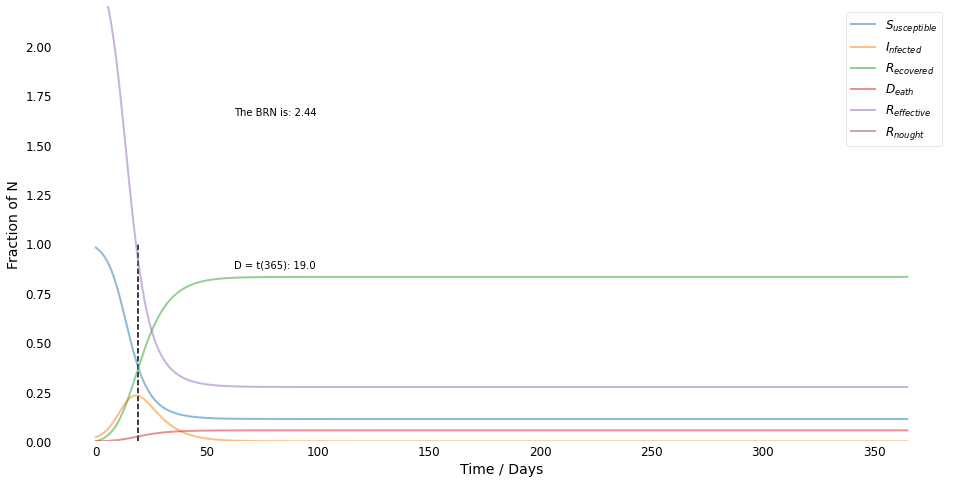

In [6]:
# Reset model to initial values
model = SIRD(N = 1, I0 = 0.02, R0 = 0, D0 = 0,
            beta = 0.39, gamma = 0.15, mu = 0.01,
            days= 365)

model.plot()
plt.show()

### Written Response

As shown by the preceeding graph, yes it is possible to derive and plot the effective reproduction number, $R_{effective}$, as a function of time, given otherwise fixed parameters. Indeed doing just that is the purpose of the ```_R_effective()``` function defined in the ```SIRD``` class above.<br>

# Question 2

Create labeled surrogate data sets. Perform a PCA/Class prediction with ovr logistic regression analysis as developed in the lecture.

* **a:** 4 blobs: Create clearly separable 4-blobs in 3d but also a ’disaster’ realization with strong overlaps. Study, show and compare elbow plots and prediction boundaries.

* **b:** 2 touching parabola spreads as shown in the lecture, but in 3d (not 2d). Study and show elbow plot and prediction boundaries.

In [7]:
### imports ###
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

## Class Explanation
As with exercise one, we start this exercise by explaining our class, i.e. what we used in order to solve the assignment question. This gives us the benefit that we can easily alter specific measures and *study* the impact thereof.

$\underline{Note}$: Bear in mind, that the following section will outline the docstrings for the different methods. Thus, these docstrings will <b>not</b> be displayed in the code when creating the class itself.

### Class Creation
The class used here is called ```Blobs_and_parabolas```. Here is how it is defined:

```python
class Blobs_and_parabolas():
    """A class to create, plot and analyize surrogate
    data with different parameters."""
```

```python
def __init__(self, n_samples = 250, n_features = 13, centers = 4,
             cluster_std = 1, center_box =(-50,50), blob = None, parabola = None):
    """This function instantiates the class blobs and parabolas,
    with the parameters defined below. Its primary benefit is that 
    we can easily alter some parameters to change data. This
    class also proceeds to create new class attributes in a similar
    manner to how it creates the train-test-split for example.

    Parameters
    ----------
    n_samples : int, optional
        How many samples do you want per blob, 250 by default
    n_features : int, optional
        How many features do you want your blob or respective 
        parabola to have, 13 by default
    centers : int, optional
        How many centers should your blobs have, 4 by default
    cluster_std : int, optional
        How large should the standard deviation be,
        if you increase this number as can be seen later the
        surrogate data will be more unclear, 1 by default
    center_box : tuple, optional
        The boundary where the surrogate data
        should be created, (-50,50) by default
    blob : [type], optional
        Do you want to create surrogate data for
        a blob set this to True? "None" by default
    parabola : [type], optional
        Do you want to create surrogate data for
        a parabola set this to True? "None" by default
    """
```

### PCA and Logistic Regression
The goal of this exercise is to make a *one-versus-rest* logistic regression in combination with PCA. In order to do so, we created a function called ```_pca_and_lr```.

```python
def _pca_and_lr(self, n_components = 2):
    """This function takes the data which is available
    within its object and performs a PCA and a logistic
    regression using the one-versus-rest logic.

    Parameters
    ----------
    n_components : int, optional
        Number of dimensions the data
        should be reduced to by PCA, 2 by default
    """
```

### Plot the decision regions
In order to see how well or poorly the data can still be separated after we used PCA and logistic regression, we created a function which can still plot the decision boundry. As you may have noticed, the ```_pca_and_lr``` function is also a *private* function, since it starts with an underscore. The PCA function is first called, and then the ```plot_decision_regions``` function.

```python
def plot_decision_regions(self, resolution=0.01):
    """Reduces the data using the _pca_and_lr function and then plots
    the decision regions to showcase how good the data could
    be separated after we reduced the data's dimensionality.

    Parameters
    ----------
    resolution : float, optional
        Parameter for the np.meshgrid function, 0.01 by default
    """
```

## Class Definition

In the next step we implemented the class described above.

$\underline{Note}$: Should any questions arise regarding the methods usage, please scroll up and review the respective docstrings.

In [8]:
class Blobs_and_parabolas():
    
    def __init__(self, n_samples = 250, n_features = 13, centers = 4, cluster_std = 1, center_box =(-50,50),
                blob = None, parabola = None):
        if blob:
            self.X, self.y = make_blobs(n_samples = n_samples,
                                        n_features = n_features,
                                        centers = centers,
                                        cluster_std = cluster_std,
                                        center_box = center_box)
        elif parabola:
            self.X, self.y = make_moons(n_samples = 10000)
            self.X = np.column_stack((self.X, np.random.choice(self.X[:,1], (len(self.X),n_features))))
            self.idx = self.y == 1
        else:
            assert("Please select either blob = True or parabola = True")
            
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                                self.X, self.y, test_size=0.3, stratify=self.y, random_state=0)
        # Standardize the features (zero mean, unit variance) 
        self.sc = StandardScaler()
        # Fit results must be used later (mu and sigma)
        self.X_train_std = self.sc.fit_transform(self.X_train)
        # Normalize test data set with mu/sigma of training data
        self.X_test_std = self.sc.transform(self.X_test)
        self.cov_mat = np.cov(self.X_train_std.T) #cov matrix from data
        self.EVal, self.EVec = np.linalg.eig(self.cov_mat)
        self.sum_EVal = sum(self.EVal)
        self.var_exp = [(i / self.sum_EVal) for i in sorted(self.EVal, reverse=True)]
        
    def _pca_and_lr(self, n_components = 2):
        # Set up PCA and logistic regression model
        self.pca = PCA(n_components= n_components)
        self.lr = LogisticRegression(multi_class='ovr', solver='liblinear')

        # Fit and transform training data, given on PCA reduction to k(=2) principle components
        self.X_train_pca = self.pca.fit_transform(self.X_train_std)
        self.X_test_pca = self.pca.transform(self.X_test_std)
        # solves task, given 3 classes (as from y_train) 
        self.lr.fit(self.X_train_pca, self.y_train)
        
    def plot_decision_regions(self, resolution=0.01):
        self._pca_and_lr()
        colors = ('r', 'b', 'g', "y")
        markers = ('s', 'v', 'o', 'p') 
        cmap = ListedColormap(colors[:len(np.unique(self.y_train))])

        # plot the decision surface
        x1_min, x1_max = self.X_train_pca[:, 0].min() - 1, self.X_train_pca[:, 0].max() + 1
        x2_min, x2_max = self.X_train_pca[:, 1].min() - 1, self.X_train_pca[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # Z is the prediction of the class, given point in plane
        Z = self.lr.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)

        # Z=f(xx1,yy1), plot classes in plane using color map but opaque
        plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        # Plot data points, given labels
        for idx, cl in enumerate(np.unique(self.y_train)):
            plt.scatter(x=self.X_train_pca[self.y_train == cl, 0], 
                        y=self.X_train_pca[self.y_train == cl, 1],
                        alpha=0.6, 
                        c=[cmap(idx)],
                        edgecolor='black',
                        marker=markers[idx], 
                        label=cl)

Here we use our defined class, in order to create surrogate blob data. One of these datasets is called (```cs```) and it has a small standard deviation along with the aforementioned default parameters, while the other is called (```uc```) and it has a higher standard deviation surrounding each cluster.

## Question 2a)
### Code for Visualizing the Datasets

In [9]:
cs = Blobs_and_parabolas(blob = True, cluster_std = 2)
uc = Blobs_and_parabolas(blob = True, cluster_std = 100)

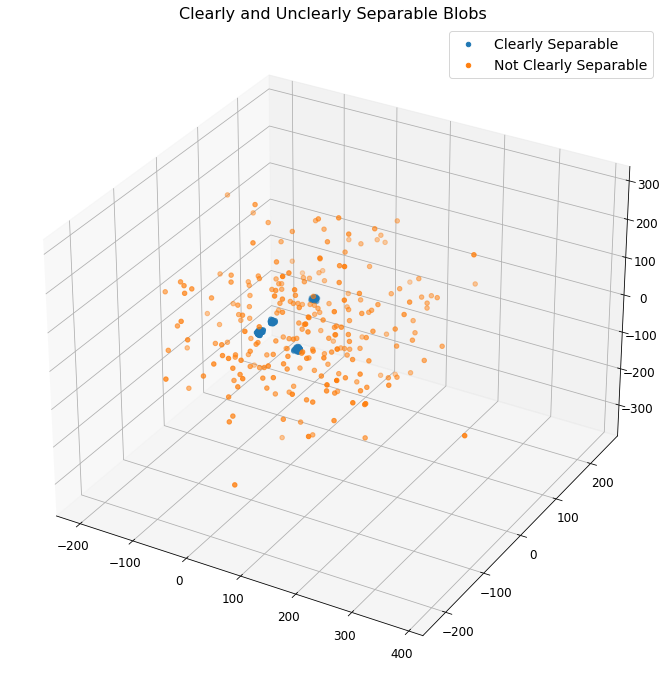

In [10]:
fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(cs.X[:, 0], cs.X[:, 1], cs.X[:, 2], label = "Clearly Separable")
ax.scatter3D(uc.X[:, 0], uc.X[:, 1], uc.X[:, 2], label= "Not Clearly Separable")
ax.legend()
plt.title("Clearly and Unclearly Separable Blobs")
plt.show()

$\underline{Note}$: The above plot provides a visualization of the surrogate data sets generated. The blue clusters represent clearly separable data while the orange dots are not easily separable. 

### Elbow Graphs - Code and Visualization

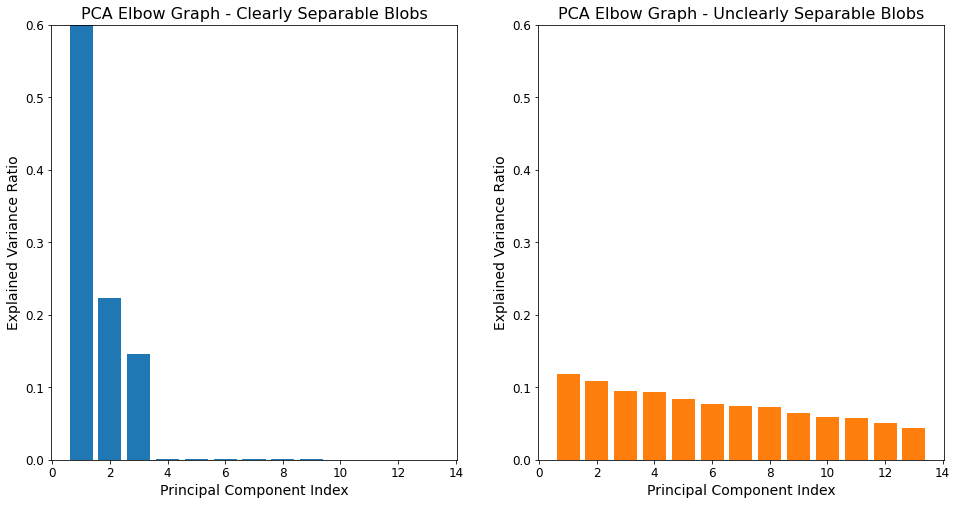

In [11]:
# Plot explained variances
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].bar(range(1,14), cs.var_exp, 
        align='center', color = "C0")
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].set_xlabel('Principal Component Index')
ax[0].set_title("PCA Elbow Graph - Clearly Separable Blobs")
ax[0].set_ylim(0,0.6)
ax[1].bar(range(1,14), uc.var_exp, 
        align='center', color = "C1")
ax[1].set_xlabel('Principal Component Index')
ax[1].set_ylim(0,0.6)
ax[1].set_ylabel('Explained Variance Ratio')
ax[1].set_title("PCA Elbow Graph - Unclearly Separable Blobs")
plt.show()

### Elbow Graphs - Takeaways
For the dataset where the blobs are clearly separable, close to 100% of the variance is explained by just three features. Accordingly, reducing the dimensionality of this dataset from 13 to three would substantially reduce the model's computational burden with very little impact on the model's ability to explain the overall variance in the dataset. 

The situation is much different for the unclearly separable blobs however. The elbow plot for that dataset shows the "degree of variance explanation" is much more evenly distributed among the 13 features, with no feature being particularly important or unimportant. As a result, reducing this model's dimensionality will have a relative strong (negative) impact on the extent to which it explains the variance in the data.

### Prediction Boundaries - Code and Visualization

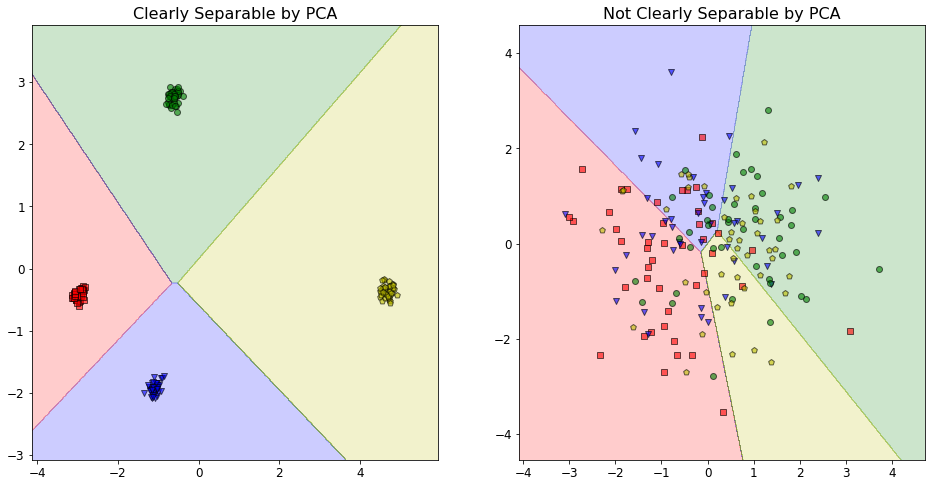

In [12]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
cs.plot_decision_regions()
plt.title("Clearly Separable by PCA")

plt.subplot(122)
uc.plot_decision_regions()
plt.title("Not Clearly Separable by PCA")
plt.show()

### Prediction Boundaries - Takeaways
The plot for the clearly separable data shows that the corresponding model has no issues correctly classifying the data using only the two most important features, as determined by the extent to which they explain variance in the data. This is not surprising, as the corresponding elbow plot showed how ~80% of the variance in the data was explained by these two features. 

Conversely, the plot for the non-separable data shows a "disaster" scenario where the model essentially has no idea what it is doing and the classifications are all over the map. Clearly, the dimensionality reduction for this dataset is not working properly. Again, this outcome is predictable when we consider the elbow plot for this data, as discussed above.

## Question 2b)

Here we create different surrogate data for the parabolas. The ```cs``` variable contains only 3D data for the two *touching* parabolas.

### Plotting the 3D Parabolas - Code and Visualization

In [13]:
cs = Blobs_and_parabolas(parabola = True, n_features = 1)

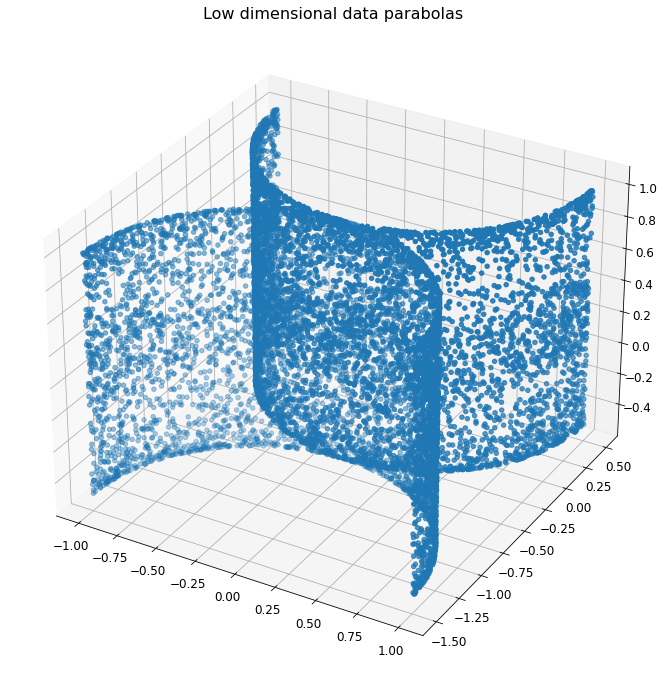

In [14]:
fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(cs.X[cs.idx, 0]-1, cs.X[cs.idx, 1], cs.X[cs.idx, 2])
ax.scatter3D(cs.X[~cs.idx, 0], cs.X[~cs.idx, 1]-1.5, cs.X[~cs.idx, 2], color = "C0")
plt.title("Low dimensional data parabolas")
plt.show()

### Plotting the 3D Parabolas - Takeaways
The parabola spread visualizations show two touching parabolas in three dimensions. One would assume the classifier to have a fairly easy time classifying the data on each side of the two parabolas; the true test of the classifier's efficacy would be how well it classifies the data points at the parabolas' respective vertices.

### Elbow Graph - Code and Visualization

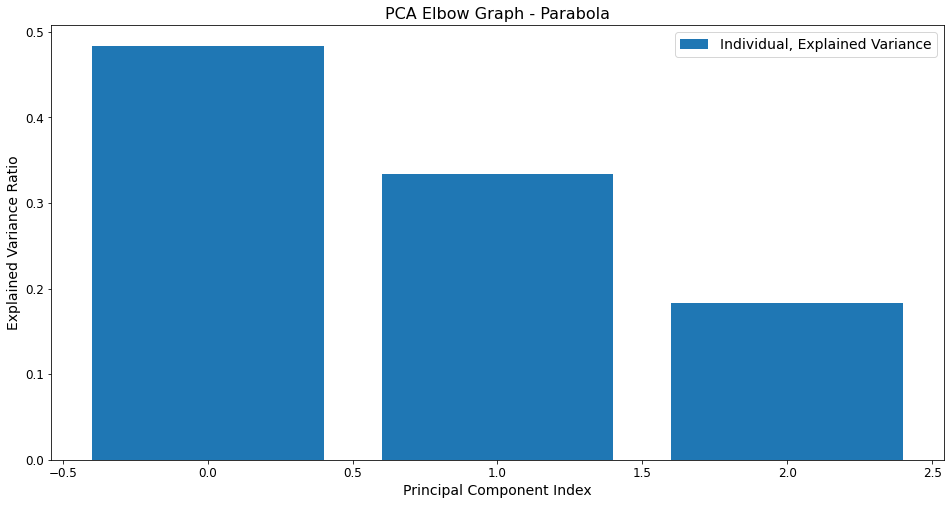

In [15]:
# Plot explained variances
fig = plt.figure(figsize = (16,8))
plt.bar(range(0,3), cs.var_exp, 
        align='center', label='Individual, Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.title("PCA Elbow Graph - Parabola")
plt.legend(loc='best')
plt.show()

### Elbow Graph - Takeaway
The "elbow" graph above actually does not really show much of the namesake elbow effect. Instead, it is a more or less linear decrease from the first feature to the third in terms of the extent to which they explain the variance, with each feature explaining approximately 15% less variance than the preceeding feature.

### Prediction Boundaries - Code and Visualization

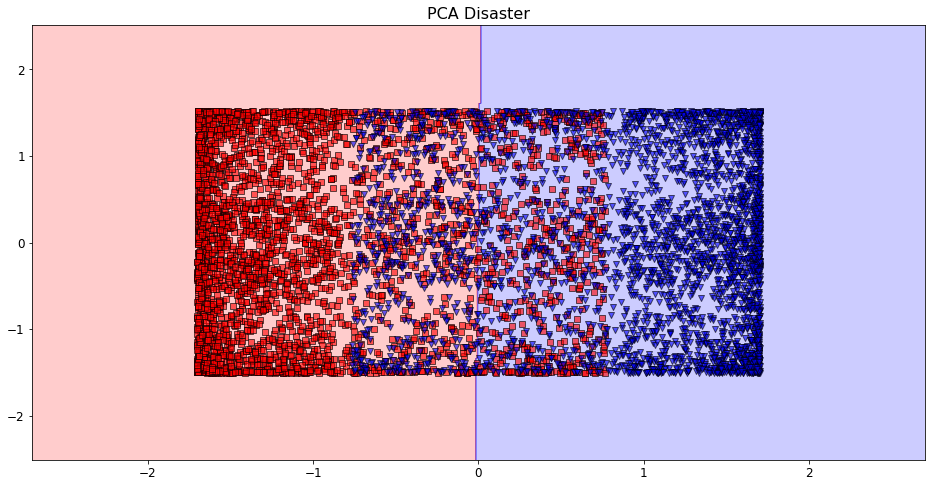

In [16]:
plt.figure(figsize = (16, 8))
cs.plot_decision_regions()
plt.title("PCA Disaster")
plt.show()

### Prediction Boundaries - Takeaways

The preceeding visualization clearly shows the model is not able to accurately classify the data. This can likely be attributed to the fact that PCA does not work effectively when we have non-linearity in our dataset, and it is clear the dataset we are analyzing here is non-linear. 